In [1]:
from CANN_DDM_models import get_DDM_simulation, get_RT, run_CANN_simulation, CANN_DDM_bump_edge_model, CANN_DDM_bump_2edge_model, CANN_DDM_base_model
from RT_analysis import plot_RT_distribution, simulate_network
import numpy as np
from matplotlib import pyplot as plt
from brainpy import math as bm
import brainpy as bp
from tqdm import tqdm

## edge-bump model (one edge)

### DDM model 
1. **Write the DDM model**

$$
dx = vdt + \sigma_W dW
$$

2. **Write the equiavlent roll-dice simulation that is statistically equiavlent to the DDM model**

suppose $dt_{\text{DDM}}=10$, i.e., we roll the dice to decide whether its right or left evidence every $10$ ms. The expectation and variance of the moving distance between every two steps are:
\begin{aligned}
\mu &= (2p-1)\Delta u = vdt_{\text{DDM}} \\
\sigma^2 &= 4\Delta u^2(1-p)p = \sigma_W^2 dt_{\text{DDM}}
\end{aligned}


Solving this we have


\begin{aligned}
\Delta u &= \sqrt{\sigma_W^2 dt_{\text{DDM}}+(vdt_{\text{DDM}})^2} \\
p &= \frac12 (1 + \frac{v dt_{\text{DDM}}}{\Delta u})
\end{aligned}

Notice if we assume $\sigma_W=0.1, dt_{\text{DDM}}=0.01$, when $v=0$ we have $\Delta u=\sigma_W \sqrt{dt_{\text{DDM}}}=0.01$. 
If we assume $v$ varies between $-10$ and $10$, then we want $\Delta u$ to vary between $0.01$ and $0.015$ 


For example, suppose $dt_{\text{DDM}}=0.01, v=0.5, \sigma_W=0.5$, after calculation we have 
$$
\Delta u \approx  0.50, p \approx 0.55
$$

### Neural Circuit Model

1. **Model Description**

There are two ways of constructing the edge attractor in our model, one using a **asymmetric kernel** (exact Laplace solution) and the other using an **symmetric kernel** (tanh approximation).

The ideal Laplace edge population has the solution:

$$
F_{\text{Laplace}}(n) = 2 \exp( -(t/t0) \cdot e^{-\Delta z (n-n_0)+\log(\log2)}) - 1 = \exp( - e^{-\Delta z (n-n_0)}) - 1
$$

The ideal Gaussian edge population has the solution:
$$
F_{\text{Gaussian}}(n) = -\tanh(\sigma_1 (n-n_0))
$$

The dynamics of edge-bump coupled network can be described as below:
\begin{aligned}
\tau_x \frac{dx(n,t)}{dt} &= -x(n,t) + \sum_{n'} J_{xx}(n,n') r_x(n',t) + I_{yx}(n,t) + I_{ext}\\
\tau_y \frac{dy(n,t)}{dt} &= -y(n,t) + \sum_{n'} J_{yy}(n,n') \tilde{r}_y(n',t) + I_{xy}(n,t) \\
r_x(n,t) &= \frac{x^2(n,t)}{1+||{x(\cdot,t)}||_2}\\
\tilde{r}_y(n,t) &= \tanh(\sigma_2 \cdot y(n,t))  \\
I_{yx}(n,t) &= c_{\text{edge}}  (\delta_{t,t_R}-\delta_{t,t_L})[y(n+1,t)-y(n,t)] \\ 
I_{xy}(n,t) &= c_{\text{bump}} x(n,t)
\end{aligned}

where $x(n,t)$, $y(n,t)$ are the synaptic inputs to the edge / bump neuron of index $n$ at time $t$, $r_x$ is the instantenous firing rate of bump neuron, and $\tilde{r}_y$ is the relative firing rate of edge neuron normalized between -1 and 1 ($\tilde{r}_y(n,t) = \frac{2(r_y-\min\{r_{y}\})}{\max\{r_{y}\}-\min\{r_{y}\}}-1$).

2. **Equivalent Condition between two kernels**

Let $\frac{d}{dn}F_{\text{Laplace}}(n_0) = \frac{d}{dn}F_{\text{Gaussian}}(n_0) $ we have:

$$
\sigma_1 = 2 e^{-1} \cdot \Delta z
$$

3. **Compute the theoretical speed of the moving edge (with symmetric kernel) given the input from the bump**

Let's consider a simple scenario in which the center of the bump is always anchored with the center of the edge. Assuming the edge moves towards right with the speed $v$, i.e., the edge center can be described as:

\begin{equation}
n_y^*(t) = \begin{cases}
n_0,  \quad t\leq t_0\\ 
n_0+v(t-t_0), \quad t>t_0
\end{cases}
\end{equation}

Correspondingly, the solution of the edge within the system is:

\begin{equation}
\hat{y}(n,t) = \begin{cases}
-\tanh(\sigma_1 (n-n_0)), \quad t\leq t_0\\ 
-\tanh(\sigma_1 (n-n_0-v(t-t_0))), \quad t>t_0

\end{cases}
\end{equation}


For $t > t_0$ we have:

\begin{aligned}
\frac{d}{dt}\hat{y}(n_y^*(t),t) &= -\hat{y}(n_y^*(t),t) + \sum_{n'} J_{yy}(n_y^*(t),n') \tilde{r}_y(n',t) + c_{\text{bump}}  x(n^*,t)\\
                                &= c_{\text{bump}} x(n^*, t)            
\end{aligned}

On the other hand from the assumption we have:
\begin{aligned}
\frac{d}{dt}\hat{y}(n_y^*(t),t) &= (1-\tanh^2(\sigma_1 (n^*-n_0-v(t-t_0))))\cdot \sigma_1 v \\
                                &= \sigma_1 v
\end{aligned}

Thus we have

$$
v = \frac{c_{\text{bump}}}{\sigma_1} x(n^*,t)
$$
 
In the demo shown below, we have $c_{\text{bump}}=1$, $\sigma_1=0.5$ and $x(n^*, t) \approx 0.57$, so the velocity is:

$$
v \approx 1.04 c_{\text{bump}}
$$

## Two types of edge kernels

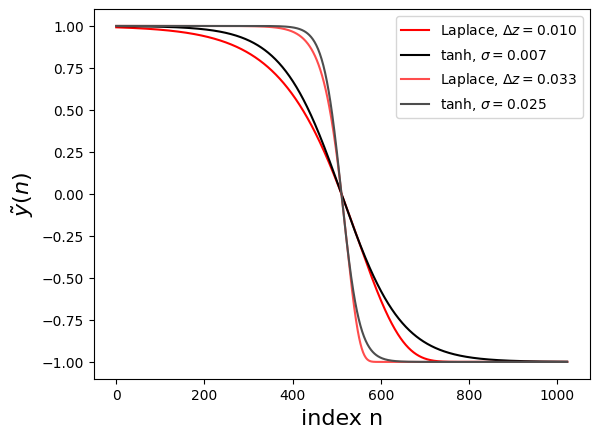

In [ ]:
### DDM parameters
dt = 1. # unit: ms
dt_DDM = 10. # unit: ms; make sure the timescale of DDM is no smaller than the timecale of network sim
# parameters for DDM model
v = 0.5
sig_W = .196
boundary = 1
seed = 2025
### Laplace network model parameters

dur1 = 500 # unit: ms
dur2 = 1500
#dur2 = 0
num=1024
tau_bump = .1
tau_edge = 1.
beta = 2
c1 = 1
c2 = 1
offset = 3.85

delta_z_all = np.linspace(1/100, 1/30, 2)
J0_bump = 4
J0_edge = 1
a = 0.25
A = 10
edge_type = 'Laplace'
t_prep = (dur1 + 0.1 * dur2)
clicks_left, clicks_right, l, p = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
reds = [(1, 1-x, 1-x) for x in np.linspace(1, 0.7, 2)]
blacks = [(1-x, 1-x, 1-x) for x in np.linspace(1, 0.7, 2)]
for i, delta_z in enumerate(delta_z_all):
    my_model1 = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                 tau_bump = tau_bump,
                                 J0_edge=J0_edge, edge_offset=offset,
                                 optimize_offset=False,
                                 t_prep = t_prep, a=a, A=A,
                                beta=beta, edge_type='Laplace', delta_z=delta_z, seed=seed, boundary=boundary)
    my_model2 = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                 tau_bump = tau_bump,
                                 J0_edge=J0_edge, edge_offset=offset,
                                 optimize_offset=False,
                                 t_prep = t_prep, a=a, A=A,
                                beta=beta, edge_type='tanh', delta_z=delta_z, seed=seed, boundary=boundary)
    sigma = 2 * np.exp(-1) *delta_z
    plt.plot(my_model1.s0, color=reds[i], label=f'Laplace, $\Delta z={delta_z:.3f}$')
    plt.plot(my_model2.s0, color=blacks[i], label=f'tanh, $\sigma = {sigma:.3f}$')
plt.xlabel('index n', fontsize=16)
plt.ylabel(r'$\tilde{y}(n)$', fontsize=16)
plt.legend()

## Constant speed

In [ ]:
### DDM parameters
dt = 1. # unit: ms
dt_DDM = 10. # unit: ms; make sure the timescale of DDM is no smaller than the timecale of network sim
# parameters for DDM model
v = 0.5
sig_W = .5
boundary = 0.8
seed = 2025
### Laplace network model parameters

dur1 = 500 # unit: ms
dur2 = 1500
#dur2 = 0
num=1024
tau_bump = .1
tau_edge = 1.
beta = 2
c1 = 1 #coff from bump to edge
c2 = 1 #coff from edge to bump
offset = 3.85
delta_z = 1/40
J0_bump = 4
J0_edge = 1
a = 0.25
A = 10
edge_type = 'tanh'
t_prep = (dur1 + 0.1 * dur2)
clicks_left, clicks_right, l, p = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                 tau_bump = tau_bump,
                                 J0_edge=J0_edge, edge_offset=offset,
                                 optimize_offset=False,
                                 t_prep = t_prep, a=a, A=A,
                                beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed, boundary=boundary)
mon_vars=['u','v', 's' , 'Ishift', 'u_pos', 'u_dpos', 's_pos', 'Ius', 'I_pause']
runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt)

### plot the dynamics
mask = my_model.mask

reds = [(1, 1-x, 1-x) for x in np.linspace(1, 0.2, 3)]
blues = [(1-x, 1-x, 1) for x in np.linspace(1, 0.2, 3)]
blacks = [(1-x, 1-x, 1-x) for x in np.linspace(1, 0.2, 3)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  


for idx, t in enumerate(np.array([600, 1000, 1500])-1):
    axes[0].plot(runner.mon.u[int(t), mask], color=blacks[idx])
    axes[0].plot(np.tanh(my_model.beta * runner.mon.s[int(t), mask]), color=reds[idx], label=f'Time {t+1}')
    
axes[0].set_ylim([-1.1, 1.1])

axes[0].legend()
axes[0].set_title("State Variables Over Time")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Relative Firing Rate")


axes[1].plot(runner.mon.u_pos, color=blacks[0], label='bump')
axes[1].plot(runner.mon.s_pos, color=reds[0], label='edge')
axes[1].legend()
axes[1].set_xticks([0, 600, 1000, 1500])
axes[1].set_xticklabels([0, 'Trial Start', 1000, 1500])
axes[1].set_xlabel("Time [ms]", fontsize=12)
axes[1].set_ylabel("(Relative) Position", fontsize=12)
axes[1].set_ylim([-1,1])
axes[1].set_title("Positions As a Function of Time")
axes[1].hlines(boundary, xmin=0, xmax=dur1+dur2, linestyle='--')
axes[1].hlines(-boundary, xmin=0, xmax=dur1+dur2, linestyle='--')


plt.tight_layout()  
param_text = fr"Parameters: $v={v}, \tau_{{\text{{bump}}}}={tau_bump}, \tau_{{\text{{edge}}}}={tau_edge}, a={a}, c_1={c1}$"
plt.figtext(0.5, 0.02, param_text, ha="center", fontsize=12, fontweight="bold")
plt.show()
du = np.mean(np.abs(np.diff(runner.mon.s_pos[int(t_prep)+200:int(t_prep)+400].T))) 
print(fr'The real delta_u is {du}')

  0%|          | 0/2000 [00:00<?, ?it/s]

AttributeError: 'CANN_DDM_bump_edge_model' object has no attribute 'c1_dyn'

In [ ]:
display_vars = ['u',  's']
dynamical_vars = [{'ys': getattr(runner.mon, var)[:, mask], 'xs': my_model.x[mask], 'label': var} for var in display_vars]
# dynamical_vars=[{'ys': runner.mon.u, 'xs': my_model.x, 'legend': 'u'},
#                         {'ys': runner.mon.Ishift, 'xs': my_model.x, 'legend': 'Ishit'}]
bp.visualize.animate_1D(
        dynamical_vars=dynamical_vars,
        frame_step=10,
        frame_delay=50,
        show=True,
        save_path='test.gif',
        ylim=[-1.1,1.1]
    )

## Dynamically adjusting speed assuming log evidence space

$$

v(x) = v_0 \cdot \alpha^{-(x-x_0)}
$$

  0%|          | 0/2000 [00:00<?, ?it/s]

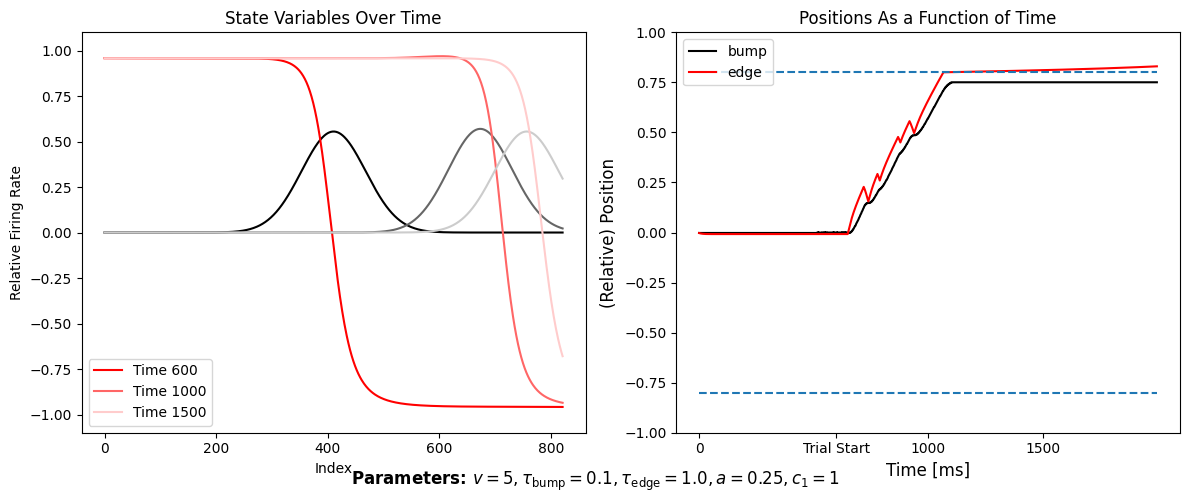

The real delta_u is 0.002543209819123149


In [5]:
### DDM parameters
dt = 1. # unit: ms
dt_DDM = 10. # unit: ms; make sure the timescale of DDM is no smaller than the timecale of network sim
# parameters for DDM model
v = 5
sig_W = .5
boundary = 0.8
seed = 2025
### Laplace network model parameters

dur1 = 500 # unit: ms
dur2 = 1500
#dur2 = 0
num=1024
tau_bump = .1
tau_edge = 1.
beta = 2
c1 = 1 #coff from bump to edge
c2 = 1 #coff from edge to bump
alpha = 2
speed_mode = 'log'
offset = 3.85
delta_z = 1/40
J0_bump = 4
J0_edge = 1
a = 0.25
A = 10
edge_type = 'tanh'
t_prep = (dur1 + 0.1 * dur2)
clicks_left, clicks_right, l, p = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                 tau_bump = tau_bump,
                                 J0_edge=J0_edge, edge_offset=offset,
                                 optimize_offset=False,
                                 t_prep = t_prep, a=a, A=A,
                                beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed, boundary=boundary, speed_mode=speed_mode, alpha=alpha)
mon_vars=['u','v', 's' , 'Ishift', 'u_pos', 'u_dpos', 's_pos', 'Ius', 'I_pause', 'c1_dyn']
runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt)

### plot the dynamics
mask = my_model.mask

reds = [(1, 1-x, 1-x) for x in np.linspace(1, 0.2, 3)]
blues = [(1-x, 1-x, 1) for x in np.linspace(1, 0.2, 3)]
blacks = [(1-x, 1-x, 1-x) for x in np.linspace(1, 0.2, 3)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  


for idx, t in enumerate(np.array([600, 1000, 1500])-1):
    axes[0].plot(runner.mon.u[int(t), mask], color=blacks[idx])
    axes[0].plot(np.tanh(my_model.beta * runner.mon.s[int(t), mask]), color=reds[idx], label=f'Time {t+1}')
    
axes[0].set_ylim([-1.1, 1.1])

axes[0].legend()
axes[0].set_title("State Variables Over Time")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Relative Firing Rate")


axes[1].plot(runner.mon.u_pos, color=blacks[0], label='bump')
axes[1].plot(runner.mon.s_pos, color=reds[0], label='edge')
axes[1].legend()
axes[1].set_xticks([0, 600, 1000, 1500])
axes[1].set_xticklabels([0, 'Trial Start', 1000, 1500])
axes[1].set_xlabel("Time [ms]", fontsize=12)
axes[1].set_ylabel("(Relative) Position", fontsize=12)
axes[1].set_ylim([-1,1])
axes[1].set_title("Positions As a Function of Time")
axes[1].hlines(boundary, xmin=0, xmax=dur1+dur2, linestyle='--')
axes[1].hlines(-boundary, xmin=0, xmax=dur1+dur2, linestyle='--')


plt.tight_layout()  
param_text = fr"Parameters: $v={v}, \tau_{{\text{{bump}}}}={tau_bump}, \tau_{{\text{{edge}}}}={tau_edge}, a={a}, c_1={c1}$"
plt.figtext(0.5, 0.02, param_text, ha="center", fontsize=12, fontweight="bold")
plt.show()
du = np.mean(np.abs(np.diff(runner.mon.s_pos[int(t_prep)+200:int(t_prep)+400].T))) 
print(fr'The real delta_u is {du}')

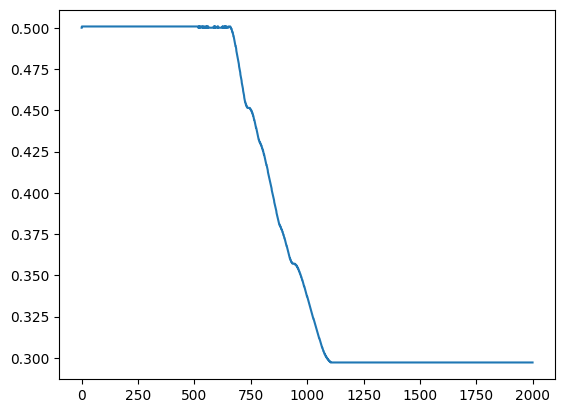

In [6]:
plt.plot(runner.mon.c1_dyn)

## plot $v_{\text{edge}}$ against $c_1$

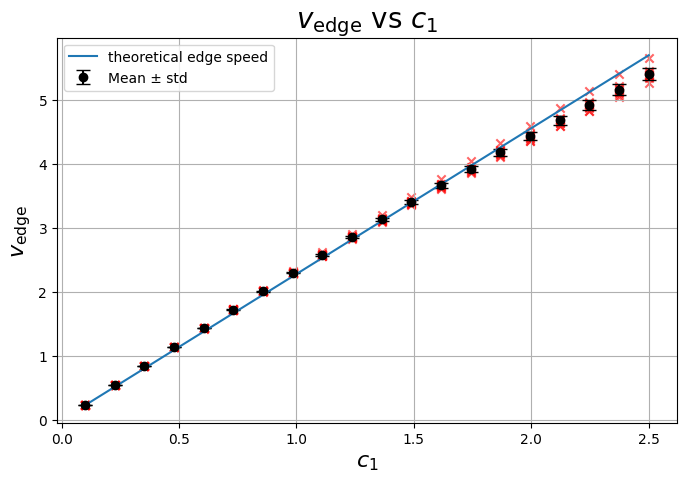

In [ ]:
### DDM parameters
dt = 1.  # unit: ms
dt_DDM = 10.  # unit: ms
v_all = np.linspace(0, 1, 20)
sig_W = 1
boundary = 0.7
### Laplace network model parameters
dur1 = 500  # ms
dur2 = 1000  # ms
num = 1024
tau_bump = 0.1
tau_edge = 1
beta = 2
offset = 3.85
delta_z = 1 / 40
J0_bump = 1
J0_edge = 1
a = 0.25
A = 10

edge_type = 'tanh'
t_prep = (dur1 + 0.1 * dur2)
c1_all = np.linspace(0.1, 2.5, 20)
c2 = 1
num_seeds = 10

# List to store Δu_pos for each c1 and seed
all_moving_distances = []
v_edge = []
for c1 in tqdm(c1_all):
    moving_distances_per_c1 = []
    v_edge_per_c1 = []
    for i in range(num_seeds):
        seed = 2025 + i  # change seed for each simulation
        clicks_left, clicks_right, _, _ = get_DDM_simulation(v_all[0], sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
        
        my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                            tau_bump=tau_bump,
                                            J0_edge=J0_edge, edge_offset=offset,
                                            optimize_offset=False,
                                            t_prep=t_prep, a=a, A=A,
                                            beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed)
        
        mon_vars = ['u', 'v', 's', 'Ishift', 'u_pos', 'u_dpos', 's_pos', 'Ius']
        runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt, progress_bar=False)
        
        #delta_u = bm.mean(bm.abs(runner.mon.u_dpos[int(t_prep):int(t_prep)+200])) 
        delta_u = bm.mean(bm.abs(bm.diff(runner.mon.s_pos[int(t_prep):int(t_prep)+200]))) 
        moving_distances_per_c1.append(float(delta_u))
        v_edge_per_c1.append(delta_u / dt * 1e3)
    all_moving_distances.append(moving_distances_per_c1)
    v_edge.append(v_edge_per_c1)

# Convert to numpy array for easier computation of mean and std
all_moving_distances = np.array(all_moving_distances)  # shape (len(c1_all), num_seeds)
v_edge = np.array(v_edge)

plt.figure(figsize=(8, 5))
# Plot scatter points for each c1 value with red 'x' markers
for i, c1 in enumerate(c1_all):
    y_vals = v_edge[i]
    x_vals = [c1] * len(y_vals)
    plt.scatter(x_vals, y_vals, alpha=0.6, marker='x', color='red')

# Compute mean and standard deviation, then plot error bars
means = np.mean(v_edge, axis=1)
stds = np.std(v_edge, axis=1)
plt.errorbar(c1_all, means, yerr=stds, fmt='o', color='black', capsize=5, label='Mean ± std')


# plot the theoretical speed
v_pred = lambda sigma, c1, bump_height: c1 / sigma * bump_height 
plt.plot(c1_all, [v_pred(0.5/beta, c1, 0.57) for c1 in c1_all], label = 'theoretical edge speed')

plt.xlabel(r'$c_1$', fontsize=16)
plt.ylabel(r'$v_{\text{edge}}$', fontsize=16)

plt.title(r'$v_{\text{edge}}$ vs $c_1$', fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

## plot $\Delta u$ against $c_2$

In [ ]:
### DDM parameters
dt = 1.  # unit: ms
dt_DDM = 10.  # unit: ms
v_all = np.linspace(0, 1, 20)
sig_W = 1
boundary = 0.9

### Laplace network model parameters
dur1 = 500  # ms
dur2 = 1000  # ms
num = 1024
tau_bump = 0.1
tau_edge = 1
beta = 2
offset = 3.85
delta_z = 1 / 40
J0_bump = 1
J0_edge = 1
a = 0.25
A = 10

edge_type = 'tanh'
t_prep = (dur1 + 0.1 * dur2)

c1 = 1
c2_all = np.linspace(0.1, 3, 20)

num_seeds = 10

# List to store Δu_pos for each c1 and seed
all_moving_distances = []

for c2 in tqdm(c2_all):
    moving_distances_per_c1 = []
    for i in range(num_seeds):
        seed = 2025 + i  # change seed for each simulation
        clicks_left, clicks_right, _, _ = get_DDM_simulation(v_all[0], sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
        
        my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                            tau_bump=tau_bump,
                                            J0_edge=J0_edge, edge_offset=offset,
                                            optimize_offset=False,
                                            t_prep=t_prep, a=a, A=A,
                                            beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed)
        
        mon_vars = ['u', 'v', 's', 'Ishift', 'u_pos', 'u_dpos', 's_pos', 'Ius']
        runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt, progress_bar=False)
        
        delta_u = bm.mean(bm.abs(runner.mon.u_dpos[int(t_prep):int(t_prep)+200])) * dt_DDM / dt
        moving_distances_per_c1.append(float(delta_u))
    
    all_moving_distances.append(moving_distances_per_c1)

# Convert to numpy array for easier computation of mean and std
all_moving_distances = np.array(all_moving_distances)  # shape (len(c1_all), num_seeds)

plt.figure(figsize=(8, 5))
# Plot scatter points for each c1 value with red 'x' markers
for i, c2 in enumerate(c2_all):
    y_vals = all_moving_distances[i]
    x_vals = [c2] * len(y_vals)
    plt.scatter(x_vals, y_vals, alpha=0.6, marker='x', color='red')

# Compute mean and standard deviation, then plot error bars
means = np.mean(all_moving_distances, axis=1)
stds = np.std(all_moving_distances, axis=1)
plt.errorbar(c2_all, means, yerr=stds, fmt='o', color='black', capsize=5, label='Mean ± std')

plt.xlabel(r'$c_1$', fontsize=12)
plt.ylabel(r'$\Delta u_{\text{pos}}$', fontsize=12)
plt.title(r'$\Delta u_{\text{pos}}$ vs $c_2$')
plt.grid(True)
plt.legend()
plt.show()

## plot $v_{\text{edge}}$ against the drift rate $v$


In [ ]:
# ### DDM parameters
# dt = 1.  # unit: ms
# dt_DDM = 10.  # unit: ms
# v_all = np.linspace(0, 1, 20)
# sig_W = 1
# boundary = 0.9

# ### Laplace network model parameters
# dur1 = 500  # ms
# dur2 = 1000  # ms
# num = 1024
# tau_bump = 0.1
# tau_edge = 1
# beta = 2
# offset = 3.85
# delta_z = 1 / 40
# J0_bump = 1
# J0_edge = 1
# a = 0.25
# A = 10

# edge_type = 'tanh'
# t_prep = (dur1 + 0.1 * dur2)

# c1 = 1
# c2 = 1

# num_seeds = 10

# # List to store Δu_pos for each c1 and seed
# all_moving_distances = []

# for v in tqdm(v_all):
#     moving_distances_per_c1 = []
#     for i in range(num_seeds):
#         seed = 2025 + i  # change seed for each simulation
#         clicks_left, clicks_right, _, _ = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
        
#         my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
#                                             tau_bump=tau_bump,
#                                             J0_edge=J0_edge, edge_offset=offset,
#                                             optimize_offset=False,
#                                             t_prep=t_prep, a=a, A=A,
#                                             beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed)
        
#         mon_vars = ['u', 'v', 's', 'Ishift', 'u_pos', 'u_dpos', 's_pos', 'Ius']
#         runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt, progress_bar=False)
        
#         delta_u = bm.mean(bm.abs(runner.mon.u_dpos[int(t_prep):int(t_prep)+200])) * dt_DDM / dt
#         moving_distances_per_c1.append(float(delta_u))
    
#     all_moving_distances.append(moving_distances_per_c1)

# # Convert to numpy array for easier computation of mean and std
# all_moving_distances = np.array(all_moving_distances)  # shape (len(c1_all), num_seeds)

plt.figure(figsize=(8, 5))
# Plot scatter points for each c1 value with red 'x' markers
for i, v in enumerate(v_all):
    y_vals = all_moving_distances[i]
    x_vals = [v] * len(y_vals)
    plt.scatter(x_vals, y_vals, alpha=0.6, marker='x', color='red')

# Compute mean and standard deviation, then plot error bars
means = np.mean(all_moving_distances, axis=1)
stds = np.std(all_moving_distances, axis=1)
plt.errorbar(v_all, means, yerr=stds, fmt='o', color='black', capsize=5, label='Mean ± std')
plt.ylim([0, 0.02])
plt.xlabel(r'$v$', fontsize=12)
plt.ylabel(r'$\Delta u_{\text{pos}}$', fontsize=12)
plt.title(r'$\Delta u_{\text{pos}}$ vs $v$')
plt.grid(True)
plt.legend()
plt.show()


## RT distribution 


In [2]:
# default_DDM_params = {
#     'dt': 1.,
#     'dt_DDM': 10.,
#     'v': 0.5,
#     'sig_W': .5,
#     'boundary': .8,
# }

# default_CANN_params = {
#     'dur1': 500,
#     'dur2': 4000,
#     'edge_type': 'tanh',
#     'num': 1024,
#     'tau_bump': 0.1,
#     'tau_edge': 1,
#     'beta': 2,
#     'offset': 3.85,
#     'delta_z': 1/40,
#     'J0_bump': 4,
#     'J0_edge': 1,
#     'a': 0.25,
#     'A': 10,
#     'c2': 1
# }
RT_corr, RT_incorr = simulate_network(num_trials=5000)

 10%|█         | 516/5000 [08:44<1:12:51,  1.03it/s]

: 

Discrete simulation parameters: step length dl = 0.05025, probability p = 0.54975


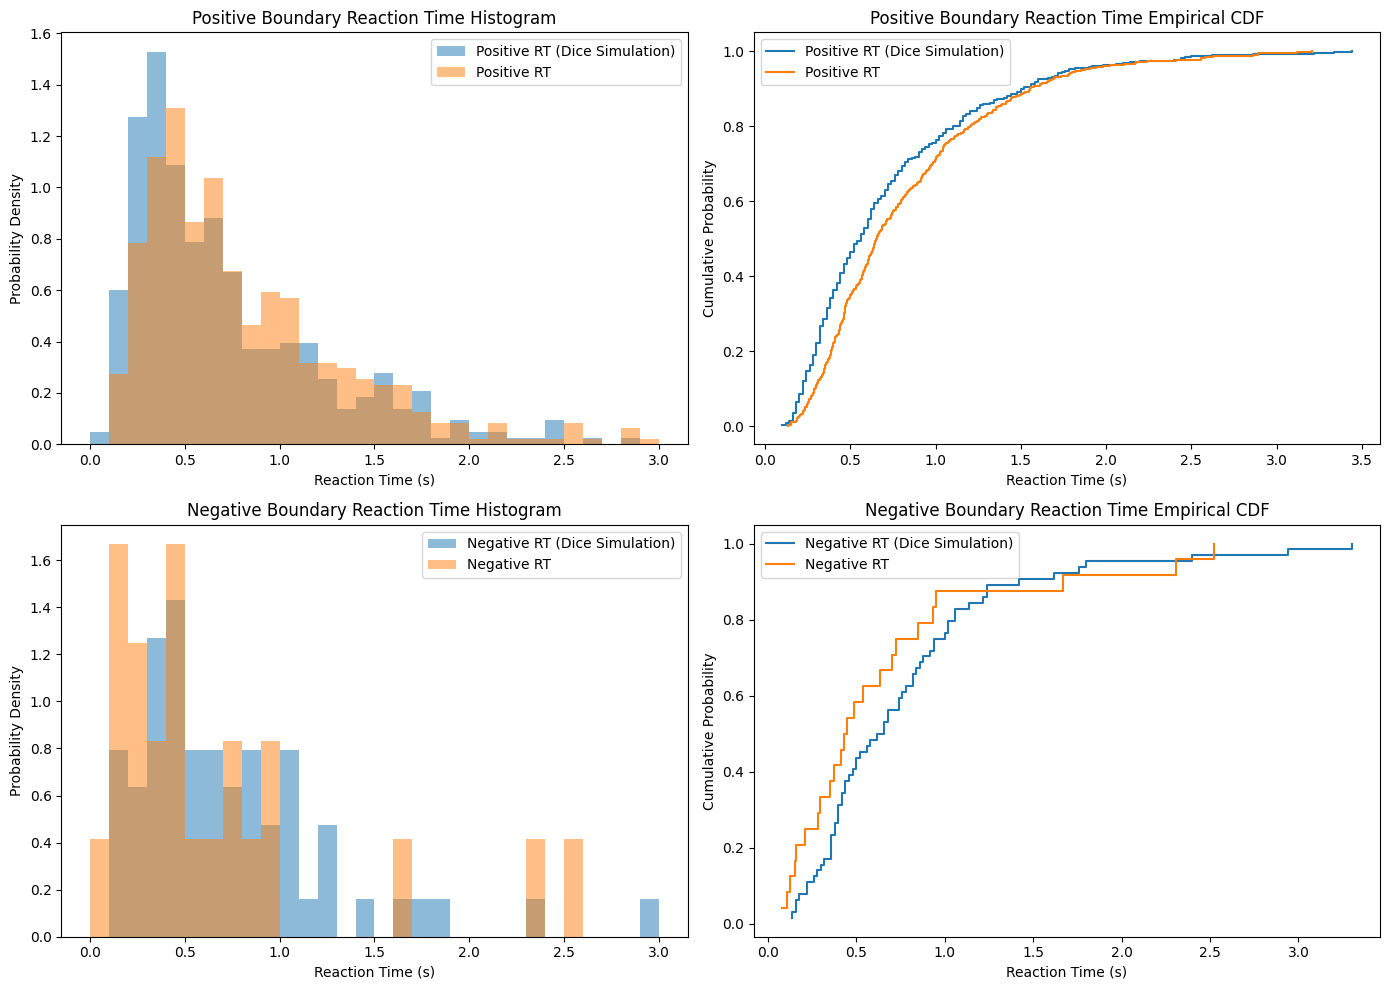

In [10]:
pos_RT_sim, neg_RT_sim = plot_RT_distribution(v=.5, sig_W=.5, B=.5, dt=0.001, dt_dice=0.01, n_trials=500, seed=2024, max_steps=3100, pos_RT=RT_corr/1e3, neg_RT=RT_incorr/1e3)



# 计算相同分位数
quantiles = np.linspace(0, 100, 100)
q1 = np.percentile(rt1, quantiles)
q2 = np.percentile(rt2, quantiles)

# 画 QQ plot
plt.figure(figsize=(6,6))
plt.plot(q1, q2, 'o')
plt.plot([min(q1.min(), q2.min()), max(q1.max(), q2.max())],
         [min(q1.min(), q2.min()), max(q1.max(), q2.max())],
         'r--')  # 45度参考线
plt.xlabel("Quantiles of RT1")
plt.ylabel("Quantiles of RT2")
plt.title("QQ Plot (Manual)")
plt.grid(True)
plt.show()



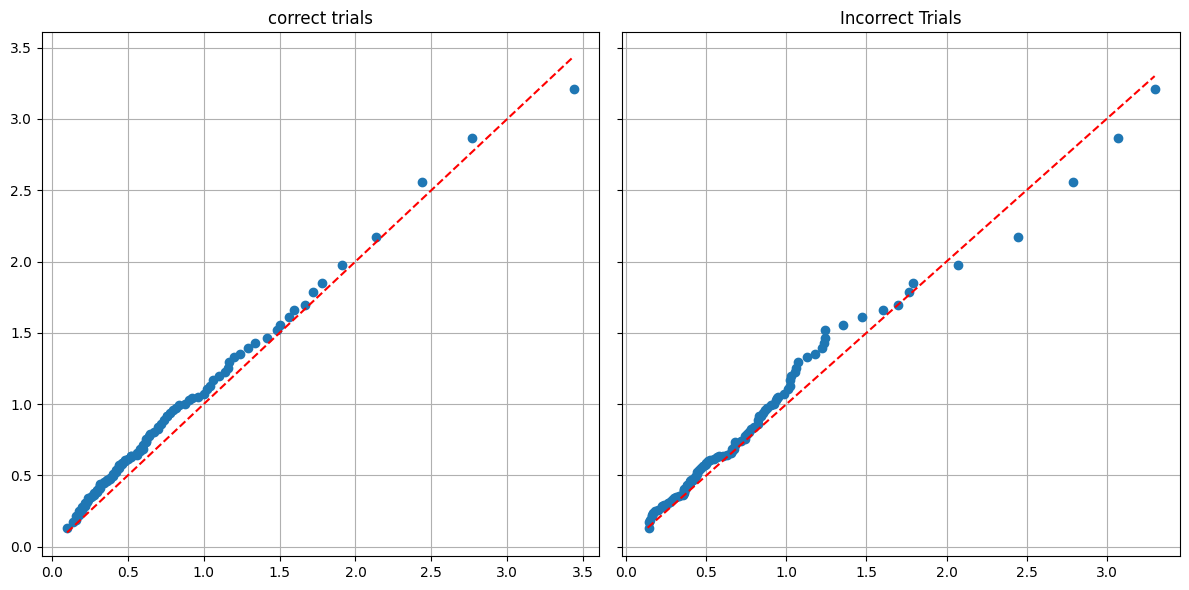

In [11]:
import numpy as np
import matplotlib.pyplot as plt



quantiles = np.linspace(0, 100, 100)
q_corr = np.percentile(RT_corr / 1e3, quantiles)  
q_incorr = np.percentile(RT_incorr/1e3, quantiles)

q_pos = np.percentile(pos_RT_sim, quantiles)
q_neg = np.percentile(neg_RT_sim, quantiles)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Positive RT
axs[0].plot(q_pos, q_corr, 'o')
axs[0].plot([min(q_pos.min(), q_corr.min()), max(q_pos.max(), q_corr.max())],
            [min(q_pos.min(), q_corr.min()), max(q_pos.max(), q_corr.max())],
            'r--')
axs[0].set_title("correct trials")
#axs[0].set_xlabel("Quantiles of pos_RT_sim")
#axs[0].set_ylabel("Quantiles of RT_corr (s)")
axs[0].grid(True)

# Negative RT
axs[1].plot(q_neg, q_corr, 'o')
axs[1].plot([min(q_neg.min(), q_corr.min()), max(q_neg.max(), q_corr.max())],
            [min(q_neg.min(), q_corr.min()), max(q_neg.max(), q_corr.max())],
            'r--')
axs[1].set_title("Incorrect Trials")
#axs[1].set_xlabel("Quantiles of neg_RT_sim")
axs[1].grid(True)

plt.tight_layout()
plt.show()





## Plot neural activities in evidence space 

In [55]:
### DDM parameters
dt = 1. # unit: ms
dt_DDM = 10. # unit: ms; make sure the timescale of DDM is no smaller than the timecale of network sim
# parameters for DDM model
v = 5
sig_W = .5
boundary = 0.8
seed = 2025
### Laplace network model parameters

dur1 = 500 # unit: ms
dur2 = 1500
#dur2 = 0
num=1024
tau_bump = .1
tau_edge = 1.
beta = 2
c1 = 1 #coff from bump to edge
c2 = 1 #coff from edge to bump
offset = 3.85
delta_z = 1/40
J0_bump = 4
J0_edge = 1
a = 0.25
A = 10
edge_type = 'tanh'
t_prep = (dur1 + 0.1 * dur2)
clicks_left, clicks_right, l, p = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                 tau_bump = tau_bump,
                                 J0_edge=J0_edge, edge_offset=offset,
                                 optimize_offset=False,
                                 t_prep = t_prep, a=a, A=A,
                                beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed, boundary=boundary)
mon_vars=['u','v', 's' , 'Ishift', 'u_pos', 'u_dpos', 's_pos', 'Ius', 'I_pause']
runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt)



Predict 2000 steps: : 100%|██████████| 2000/2000 [00:00<00:00, 2945.63it/s]


In [100]:
### plot the dynamics
fr_bump = runner.mon.u.T
fr_edge = runner.mon.s.T
evidence_all = runner.mon.s_pos
valid_t = (np.abs(evidence_all < boundary)) * np.arange(len(evidence_all))>t_prep
             
evidence = evidence_all[valid_t]
fr_bump  = fr_bump[:,  valid_t]
fr_edge  = fr_edge[:,  valid_t]


n_bins   = 50     
bin_edges = np.linspace(0, boundary, n_bins + 1)
bin_edges = np.logspace(-0.5, np.log(0.8)/np.log(2), 20, base=2)
bin_idx   = np.digitize(evidence, bin_edges) - 1   # 0 ~ n_bins-1
heatmap_bump = np.full((np.shape(fr_bump)[0], n_bins), np.nan, dtype=float)
heatmap_edge = np.full((np.shape(fr_edge)[0], n_bins), np.nan, dtype=float)

for b in range(n_bins):
    t_sel = bin_idx == b                 # 该 bin 覆盖的所有时间点
    if not np.any(t_sel):                # 该 bin 可能没有采样点
        continue
    heatmap_bump[:, b] = fr_bump[:, t_sel].mean(axis=1)
    heatmap_edge[:, b] = fr_edge[:, t_sel].mean(axis=1)
    


In [101]:
bin_idx

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0,  0,  1,  2,  3,  4,  5,  5,  6,  7,  8,  9, 10,  9,  8,
        7,  6,  5,  3,  2

### study how c is correlated with the averaged moving distance of the bump

In [ ]:
### DDM parameters
dt = 1. # unit: ms
dt_DDM = 10. # unit: ms; make sure the timescale of DDM is no smaller than the timecale of network sim
# parameters for DDM model
v_all = np.linspace(0, 1, 10)
sig_W = 1
boundary = 0.5
seed = 2025

### Laplace network model parameters

dur1 = 500 # unit: ms
dur2 = 1000
#dur2 = 0
num=1024
tau_bump = 0.1
tau_edge = 1
beta = 2
offset = 3.85
delta_z = 1/40
J0_bump = 1
J0_edge = 1
a = 0.25
A = 10

edge_type = 'Laplace'
t_prep = (dur1 + 0.1 * dur2)
avg_moving_distance = []
c1_all = np.linspace(1,2,20)
c2 = 1
for c1_all in c1_all:

    clicks_left, clicks_right = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
    my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                    tau_bump = tau_bump,
                                    J0_edge=J0_edge, edge_offset=offset,
                                    optimize_offset=False,
                                    t_prep = t_prep, a=a, A=A,
                                    beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed)
    mon_vars=['u','v', 's' , 'Ishift', 'u_pos', 'u_dpos', 's_pos', 'Ius']
    runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt)
    #avg_moving_distance.append(bm.mean(bm.abs(bm.diff(runner.mon.s_pos[dur1:].T[0]))) * dt_DDM/dt)
    avg_moving_distance.append(bm.mean(bm.abs(runner.mon.u_dpos[dur1:])) * dt_DDM/dt)
plt.figure()
plt.plot(c1_all, avg_moving_distance)
plt.xlabel(f'$c_1$', fontsize=12)
plt.ylabel(r'$\Delta u_{\text{pos}}$', fontsize=12)

### study how $J_\text{bump}$ is correlated with the averaged moving distance of the bump

In [ ]:
### DDM parameters
dt = 1. # unit: ms
dt_DDM = 10. # unit: ms; make sure the timescale of DDM is no smaller than the timecale of network sim
# parameters for DDM model
v = 0
sig_W = 1
boundary = 0.5
seed = 2025

### Laplace network model parameters

dur1 = 500 # unit: ms
dur2 = 1000
#dur2 = 0
num=1024
tau_bump = 0.1
tau_edge = 1
beta = 2
offset = 3.85
delta_z = 1/40
J0_bump = 1
J0_bump_all = [1,2,3,4]
J0_edge = 1
a = 0.15
A = 10

edge_type = 'Laplace'
t_prep = (dur1 + 0.1 * dur2)
avg_moving_distance = []
c1 = 1
c2 = 1
for J0 in J0_bump_all:

    clicks_left, clicks_right = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
    my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                    tau_bump = tau_bump,
                                    J0_edge=J0_edge, edge_offset=offset,
                                    optimize_offset=False,
                                    t_prep = t_prep, a=a, A=A,
                                    beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed)
    mon_vars=['u','v', 's' , 'Ishift', 'u_pos', 'u_dpos', 's_pos', 'Ius']
    runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt)
    #avg_moving_distance.append(bm.mean(bm.abs(bm.diff(runner.mon.s_pos[dur1:].T[0]))) * dt_DDM/dt)
    avg_moving_distance.append(bm.mean(bm.abs(runner.mon.u_dpos[dur1:])) * dt_DDM/dt)
plt.figure()
plt.plot(J0_bump_all, avg_moving_distance)
plt.xlabel(f'$c_1$', fontsize=12)
plt.ylabel(r'$\Delta u_{\text{pos}}$', fontsize=12)

### RT Simuations

In [ ]:
### DDM parameters
dt = 1. # unit: ms
dt_DDM = 10 # unit: ms; make sure the timescale of DDM is no smaller than the timecale of network sim
# parameters for DDM model
v = .5
sig_W = .5
boundary = 0.5

### Laplace network model parameters

dur1 = 500 # unit: ms
dur2 = 2000
#dur2 = 0
num=1024
tau_bump = 0.1
tau_edge = 1
beta = 2
c1 = 1
c2 = 1
offset = 3.85
delta_z = 1/40
J0_bump = 4
J0_edge = 1
a = 0.25
A = 10
edge_type = 'Laplace'
t_prep = (dur1 + 0.1 * dur2)
pos_all = []
for seed in tqdm(bm.arange(500)):
    seed = int(seed)
    clicks_left, clicks_right, l, p = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
    my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                    tau_bump = tau_bump,
                                    J0_edge=J0_edge, edge_offset=offset,
                                    optimize_offset=False,
                                    t_prep = t_prep, a=a, A=A,
                                    beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed)
    mon_vars=['u','v', 's' ,'Ishift', 'u_pos', 'u_dpos', 's_pos', 'Ius', 'RT']
    runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt, progress_bar=False)
    pos_all.append(runner.mon.u_pos.T[0])
    my_model.reset_state()

pos_all = np.array(pos_all)




In [ ]:
def plot_RT_distribution(v=1, sig_W=1, B=1, dt=0.001, dt_dice=0.01, n_trials=500, seed=2025, max_steps=1000, pos_RT=None, neg_RT=None):
    """
    Plot reaction time (RT) distributions for positive (hits on the upper boundary)
    and negative (hits on the lower boundary) responses.

    If pos_RT and neg_RT are provided, the function will plot these values.
    Otherwise, it will simulate RTs using an Euler–Maruyama scheme.

    Parameters:
    -----------
    v : float, optional
        Drift rate.
    sig_W : float, optionalSS
        Diffusion (noise) coefficient.
    B : float, optional
        Boundary value (both +B and -B are used).
    dt : float, optional
        Time step (in seconds).
    n_trials : int, optional
        Number of trials to simulate.
    pos_RT : array_like, optional
        Reaction times for trials that hit the upper (positive) boundary.
    neg_RT : array_like, optional
        Reaction times for trials that hit the lower (negative) boundary.
    """
    np.random.seed(seed)
    bins = np.arange(0, max_steps * dt, dt_dice*2)
    # If reaction time arrays are not provided, perform Euler–Maruyama simulation.

    # # --- Euler–Maruyama Simulation ---
    # pos_RT_euler = []  # RTs for trials hitting the positive boundary (x >= B)
    # neg_RT_euler = []  # RTs for trials hitting the negative boundary (x <= -B)

    # for trial in range(n_trials):
    #     x = 0.0
    #     t = 0.0
    #     hit_boundary = False
    #     for step in range(max_steps):
    #         t += dt
    #         # Euler–Maruyama update: dX = v*dt + sig_W*sqrt(dt)*N(0,1)
    #         x += v * dt + sig_W * np.sqrt(dt) * np.random.randn()
    #         if x >= B:
    #             pos_RT_euler.append(t)
    #             hit_boundary = True
    #             break
    #         elif x <= -B:
    #             neg_RT_euler.append(t)
    #             hit_boundary = True
    #             break
    #     # If boundary is not hit within simulation_steps, record as NaN (or skip)
    #     if not hit_boundary:
    #         pos_RT_euler.append(np.nan)
    #         neg_RT_euler.append(np.nan)


    # pos_RT_euler = np.array(pos_RT_euler)
    # neg_RT_euler = np.array(neg_RT_euler)

    # --- Discrete Dice-Roll Simulation ---
    # Calculate the step length and probability for the dice-roll simulation.
    dl = np.sqrt(sig_W**2 * dt_dice + (v * dt_dice)**2)
    p = 0.5 * (1 + (v * dt_dice) / dl)
    print(f"Discrete simulation parameters: step length dl = {dl:.5f}, probability p = {p:.5f}")

    pos_RT_dice = []  # RTs for trials hitting the positive boundary (x >= B)
    neg_RT_dice = []  # RTs for trials hitting the negative boundary (x <= -B)

    for trial in range(n_trials):
        x = 0.0
        t = 0.0
        hit_boundary = False
        # Dice-roll update: move right by dl with probability p, left by dl with probability (1-p)
        for step in range(max_steps):
            t += dt_dice
            if np.random.rand() < p:
                x += dl
            else:
                x -= dl
            if x >= B:
                pos_RT_dice.append(t)
                hit_boundary = True
                break
            elif x<= -B:
                neg_RT_dice.append(t)
                hit_boundary = True
                break
        if not hit_boundary:
                pos_RT_dice.append(np.nan)
                neg_RT_dice.append(np.nan)
    pos_RT_dice = np.array(pos_RT_dice)
    neg_RT_dice = np.array(neg_RT_dice)

    # Plotting the RT distributions:
    plt.figure(figsize=(12, 10))

    # Positive boundary RT distribution
    plt.subplot(2, 1, 1)
    #plt.hist(pos_RT_euler, bins=bins_pos, density=True, alpha=0.5, label="Positive RT (Ruler Method)")
    plt.hist(pos_RT_dice, bins=bins, density=True, alpha=0.5, label="Positive RT (Dice Simulation)")
    if pos_RT is not None:
        plt.hist(pos_RT, bins=bins, density=True, alpha=0.5, label="Positive RT")
    plt.xlabel("Reaction Time (s)")
    plt.ylabel("Probability Density")
    plt.title("Positive Boundary Reaction Time Distribution")
    plt.legend()

    # Negative boundary RT distribution
    plt.subplot(2, 1, 2)
    #plt.hist(neg_RT_euler, bins=bins_neg, density=True, alpha=0.5, label="Negative RT (Ruler Method)")
    plt.hist(neg_RT_dice, bins=bins, density=True, alpha=0.5, label="Negative RT (Dice Simulation)")
    if neg_RT is not None:
        plt.hist(neg_RT, bins=bins, density=True, alpha=0.5, label="Negative RT")
    plt.xlabel("Reaction Time (s)")
    plt.ylabel("Probability Density")
    plt.title("Negative Boundary Reaction Time Distribution")
    plt.legend()

    plt.tight_layout()
    plt.show()
    return pos_RT_dice, neg_RT_dice

In [ ]:
boundary = 0.5
pos_RT, neg_RT = get_RT(pos_all, boundary=boundary, dt=dt)
pos_RT = (pos_RT - t_prep) * dt/1e3
neg_RT = (neg_RT - t_prep) * dt/1e3
#np.mean(pos_RT)
pos_RT_dice, neg_RT_dice = plot_RT_distribution(v=.5, sig_W=.5, B=boundary, pos_RT=pos_RT, neg_RT=neg_RT)


In [ ]:
pos_RT, neg_RT = get_RT(pos_all, boundary=boundary, dt=dt)

In [ ]:
plot_RT_distribution(v=.1, sig_W=.15, B=0.5, dt=0.001, dt_dice=0.01, n_trials=500)

In [ ]:
A = np.array([1,2,np.nan])
plt.hist(A)

In [ ]:
dl = 0.015
p = 0.53326
dt = 0.01
n = int(1 / dt)
np.random.seed(2027)
dice_result = np.random.binomial(1, p, n)
x = np.cumsum((dice_result-0.5)*2)*dl
plt.plot(x)

## edge-bump model v2

### two edge-bump pairs

In [ ]:
### DDM parameters
dt = .1 # unit: ms
dt_DDM = 1. # unit: ms; make sure the timescale of DDM is no smaller than the timecale of network sim
# parameters for DDM model
v = 0
sig_W = 1
boundary = 0.5
seed = 2025

### Laplace network model parameters

dur1 = 50 # unit: ms
dur2 = 100
#dur2 = 0
num=1024
tau_bump = 1.5
tau_edge = 1
beta = 2
c=5
offset = 3.85
delta_z = 1/40
J0_bump = 1
J0_edge = 1
a = 0.25
A = 10
edge_type = 'Laplace'
t_prep = (dur1 + 0.1 * dur2)
clicks_left, clicks_right = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
my_model = CANN_DDM_bump_2edge_model(num=num, c=c, J0_bump=J0_bump,
                                 tau_bump = tau_bump,
                                 J0_edge=J0_edge, edge_offset=offset,
                                 optimize_offset=False,
                                 t_prep = t_prep, a=a, A=A,
                                beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed)
mon_vars=['u','v', 's_r', 's_l', 'Ishift', 'u_pos', 'u_dpos', 'sl_pos', 'sr_pos', 'Ius_r']
runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt)

## Demonstrate the initial state is stable

In [ ]:
reds = [(1, 1-x, 1-x) for x in np.linspace(1, 0.5, 5)]
blues = [(1-x, 1-x, 1) for x in np.linspace(1, 0.5, 5)]
plt.plot(my_model.s_r0[my_model.mask], color=reds[0], label = 'right edege: t=0')
plt.plot(my_model.s_l0[my_model.mask], color=blues[0], label = 'left edege: t=0')
plt.plot(runner.mon.s_r[500, my_model.mask], '--', color=reds[-1], label = 'right edege: t=500')
plt.plot(runner.mon.s_l[500, my_model.mask], '--', color=blues[-1], label = 'left edege: t=500')
plt.legend()

## Demonstrate that the relative positions between edges and the bump does not change as the network evolves

In [ ]:
reds = [(1, 1-x, 1-x) for x in np.linspace(1, 0.1, 5)]
blues = [(1-x, 1-x, 1) for x in np.linspace(1, 0.1, 5)]
blacks = [(1-x, 1-x, 1-x) for x in np.linspace(1, 0.1, 5)]
plt.figure()
plt.plot(runner.mon.u_pos, color=blacks[0], label = 'bump')
plt.plot(runner.mon.sr_pos, color=reds[0], label = 'right edge')
plt.plot(runner.mon.sl_pos, color=blues[0], label = 'left edge')
plt.legend()
plt.xticks([0, 600, 1000, 1500], [0, 'Trial Start', 1000, 1500])
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('(Relative) Position', fontsize=12)
plt.title('Positions As a Function of Time')



In [ ]:
mask = my_model.mask
plt.figure()
reds = [(1, 1-x, 1-x) for x in np.linspace(1, 0.1, 5)]
blues = [(1-x, 1-x, 1) for x in np.linspace(1, 0.1, 5)]
blacks = [(1-x, 1-x, 1-x) for x in np.linspace(1, 0.1, 5)]
for idx, t in enumerate(np.linspace(500, 1000, 4)):

    #plt.plot(runner.mon.u[int(t),:], color = colors[idx])
    #plt.plot(runner.mon.Ishift[int(t),mask], color = colors[idx])
    plt.plot(runner.mon.u[int(t), mask], color = blacks[idx])
    plt.plot(runner.mon.s_r[int(t), mask], color = reds[idx])
    plt.plot(runner.mon.s_l[int(t), mask], color = blues[idx])
    #plt.plot(runner.mon.s_l[int(t),mask], color = colors[idx])
    #plt.plot(runner.mon.s_r[int(t),:])
    #plt.plot(runner.mon.Ishift[int(t), :])
plt.ylim([-1.1,1.1])
plt.legend()

In [ ]:
#display_vars = ['u', 's_r', 's_l', 'Ishift']
display_vars = ['s_r', 's_l', 'u']
mask = my_model.mask
dynamical_vars = [{'ys': getattr(runner.mon, var)[:, mask], 'xs': my_model.x[mask], 'label': var} for var in display_vars]
# dynamical_vars=[{'ys': runner.mon.u, 'xs': my_model.x, 'legend': 'u'},
#                         {'ys': runner.mon.Ishift, 'xs': my_model.x, 'legend': 'Ishit'}]
bp.visualize.animate_1D(
        dynamical_vars=dynamical_vars,
        frame_step=10,
        frame_delay=50,
        show=True,
        save_path='test_edge_bump_two_ways.gif',
        ylim=[-1.1,1.1]
    )


## Demonstrate that without keeping a relative distance between edges and the bump, the network does not evolve as expected

In [ ]:
### DDM parameters
dt = .1 # unit: ms
dt_DDM = 1. # unit: ms; make sure the timescale of DDM is no smaller than the timecale of network sim
# parameters for DDM model
v = 0
sig_W = 0.5
boundary = 0.5
seed = 2025

### Laplace network model parameters

dur1 = 50 # unit: ms
dur2 = 100
#dur2 = 0
num=1024
tau_bump = 1.5
tau_edge = 1
beta = 2
c=5
offset = 3.85
delta_z = 1/40
J0_bump = 1
J0_edge = 1
a = 0.25
A = 10
edge_type = 'Laplace'
init_dist_l = 0
inir_dist_r = 0
t_prep = (dur1 + 0.1 * dur2)
clicks_left, clicks_right = get_DDM_simulation(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
my_model = CANN_DDM_bump_edge_v2(num=num, c=c, J0_bump=J0_bump,
                                 tau_bump = tau_bump,
                                 J0_edge=J0_edge, edge_offset=offset, init_dist_l=init_dist_l, init_dist_r = inir_dist_r,
                                 optimize_offset=False,
                                 t_prep = t_prep, a=a, A=A,
                                beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed)
mon_vars=['u','v', 's_r', 's_l', 'Ishift', 'u_pos', 'u_dpos', 'sl_pos', 'sr_pos', 'Ius_r']
runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt)

In [ ]:
mask = my_model.mask
plt.figure()
reds = [(1, 1-x, 1-x) for x in np.linspace(1, 0.1, 5)]
blues = [(1-x, 1-x, 1) for x in np.linspace(1, 0.1, 5)]
blacks = [(1-x, 1-x, 1-x) for x in np.linspace(1, 0.1, 5)]
for idx, t in enumerate(np.linspace(500, 1000, 1)):

    #plt.plot(runner.mon.u[int(t),:], color = colors[idx])
    #plt.plot(runner.mon.Ishift[int(t),mask], color = colors[idx])
    plt.plot(runner.mon.u[int(t), mask], color = blacks[idx])
    plt.plot(runner.mon.s_r[int(t), mask], color = reds[idx])
    plt.plot(runner.mon.s_l[int(t), mask], color = blues[idx])
    #plt.plot(runner.mon.s_l[int(t),mask], color = colors[idx])
    #plt.plot(runner.mon.s_r[int(t),:])
    #plt.plot(runner.mon.Ishift[int(t), :])
plt.ylim([-1.1,1.1])
plt.legend()

In [ ]:
reds = [(1, 1-x, 1-x) for x in np.linspace(1, 0.1, 5)]
blues = [(1-x, 1-x, 1) for x in np.linspace(1, 0.1, 5)]
blacks = [(1-x, 1-x, 1-x) for x in np.linspace(1, 0.1, 5)]
plt.figure()
plt.plot(runner.mon.u_pos, color=blacks[0], label = 'bump')
plt.plot(runner.mon.sr_pos, color=reds[0], label = 'right edge')
plt.plot(runner.mon.sl_pos, color=blues[0], label = 'left edge')
plt.legend()
plt.xticks([0, 600, 1000, 1500], [0, 'Trial Start', 1000, 1500])
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('(Relative) Position', fontsize=12)
plt.title('Positions As a Function of Time')

In [ ]:
#display_vars = ['u', 's_r', 's_l', 'Ishift']
display_vars = ['s_r', 's_l', 'u']
mask = my_model.mask
dynamical_vars = [{'ys': getattr(runner.mon, var)[:, mask], 'xs': my_model.x[mask], 'label': var} for var in display_vars]
# dynamical_vars=[{'ys': runner.mon.u, 'xs': my_model.x, 'legend': 'u'},
#                         {'ys': runner.mon.Ishift, 'xs': my_model.x, 'legend': 'Ishit'}]
bp.visualize.animate_1D(
        dynamical_vars=dynamical_vars,
        frame_step=10,
        frame_delay=50,
        show=True,
        save_path='test_edge_bump_two_ways_case2.gif',
        ylim=[-1.1,1.1]
    )